In [1]:
# 1자연어처리를 위한 추가 라이브러리 설치 
!pip install konlpy # 코엔엘파이; 한국어 정보처리를 위한 파이썬 패키지. 
!pip install collections # 리스트, 튜플, 딕셔내리, 셋트 이외의 데이터형 구축 패키지
!pip install wordcloud # 아마도 워드 클라우딩 하는 패키지
!pip install sys # sys 모듈은 파이썬 인터프리터가 제공하는 변수와 함수를 직접 제어할 수 있게 해주는 모듈이다.

ERROR: Could not find a version that satisfies the requirement collections
ERROR: No matching distribution found for collections
ERROR: Could not find a version that satisfies the requirement sys
ERROR: No matching distribution found for sys


1. konlpy
https://konlpy.org/ko/latest/index.html

2.콜렉션
https://docs.python.org/ko/3/library/collections.html

In [4]:
# 2 라이브러리 imported 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import sys
from konlpy.tag import Okt
from collections import Counter  # 해시 가능한 객체를 세는 데 사용하는 딕셔너리 서브 클래스
from wordcloud import WordCloud

# 다운받은 csv를 pandas의 DataFrame 형식으로 불러옵니다.
data = pd.read_csv('train.csv')

data

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0
...,...,...,...
4995,4996,좋은 배우들로 3류영화를 찍은 안타까운 영화,0
4996,4997,진짜 드럽게 재미없다 에드워드 호퍼 그림에 배경 빼고는 볼게 아닌영화,0
4997,4998,가장 실망스러운 영화.. 지금까지 본영화중..,0
4998,4999,"이런 평점 테러, 네이버에서 좀 막아야 하는 것 아닌가?",1


In [6]:
#3 결측값 확인
def check_missing_col(dataframe):
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):  # enumerate 반복시키는 내장함수
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'총 {missing_values}개의 결측치가 존재합니다.')

        if i == len(dataframe.columns) - 1 and counted_missing_col == 0:
            print('결측치가 존재하지 않습니다')
check_missing_col(data)

결측치가 존재하지 않습니다


In [10]:
# 4 데이터 타입,사이즈 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   int64 
 1   document  5000 non-null   object
 2   label     5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


5000개의 케이스, 오븍제트 타입의 문서, 숫자데이터 확인 


In [12]:
#5 클래스 고윳값 및 분포 확인 
data['label'].value_counts()

0    2564
1    2436
Name: label, dtype: int64

1은 긍정 0 은 부정이라 주최측에서 설명; 골고루 분포 되어있음 

In [13]:
#6 그래프 그리기 위한 패키지 준비
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use("ggplot")


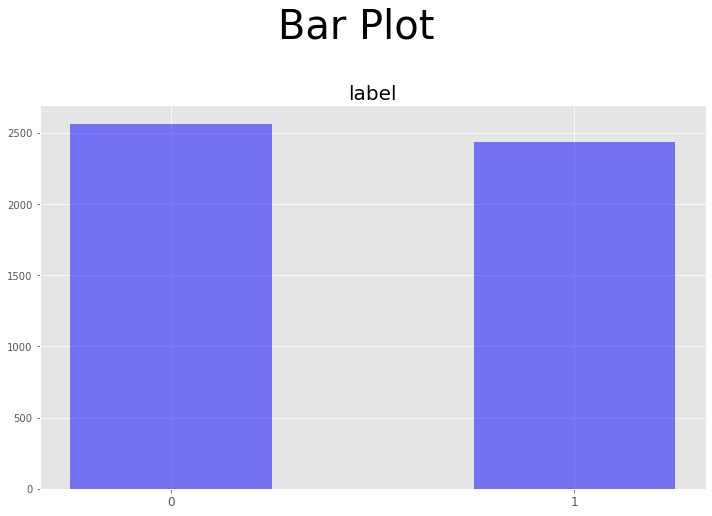

In [14]:
# 7 히스토그램 그리기
feature = data['label']

plt.figure(figsize=(10,7.5)) # 그래프 이미지 크기 설정
plt.suptitle("Bar Plot", fontsize=40) # 부제목과 폰트 크기 설정

plt.title('label', fontsize=20) # 제목과 폰트 크기 설정
temp = feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5) # 막대그래프 생성
plt.xticks(temp.keys(), fontsize=12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기

굳이 이렇게까지 할필요 있나 숫자로 다 확인 가능한데?

In [15]:
#8 리뷰길이 확인
str_len_mean = np.mean(data['document'].str.len()) # 리뷰 길이의 평균값 계산
print('리뷰의 평균 길이 :',str_len_mean)

리뷰의 평균 길이 : 27.1352


 문자수의 평균길이를 확인하는 이유는 뭘까?

In [17]:
#9.데이터 필터링을 위한 마스크 설정
mask_pos = (data.label == 1)
mask_neg = (data.label == 0)

#10.전체 / 긍정 / 부정 리뷰 집합을 설정합니다.
df_train = data.document.copy() # 전체 train 데이터
df_pos = data.loc[mask_pos,:].document # 긍정 리뷰에만 해당하는 train 데이터
df_neg = data.loc[mask_neg,:].document # 부정 리뷰에만 해당하는 train 데이터

#11. 세 집합을 리스트로 묶어줍니다.
compare = [df_train, df_pos, df_neg]

-리뷰에 이미 부정인지 긍정인지 마크가 찍혀 있는지 몰랐다. 

-데이터분석 목적 재정립: 이 데이터를 가지고 아직 알지 못하는 리뷰 데이터를 분석, 긍정인지 부정인지 분류하시오. 

In [18]:
#12 긍정 분류 확인
df_pos.head()

1            히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...
2    괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~
5       내인생에 있어 손까락에 꼽히는 영화 원작을 능가한 리메이크작
7          마음이 성숙하고 보면 다르게 보이는 영화.. 걸작이다.
8                   가슴 찡했던, 오래 기억에남을 영화!!
Name: document, dtype: object

In [19]:
#13 부정 분류 확인
df_neg.head()

0                  영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐
3                아무래도 20년도지난작품이라 지금보기는너무유치하다
4    지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.
6                성룡영화중 최악 .. 차라리 러시아워가 훨씬 나음
9                   결말 기분나쁘다 공포매니아에게 이따위 결말을
Name: document, dtype: object

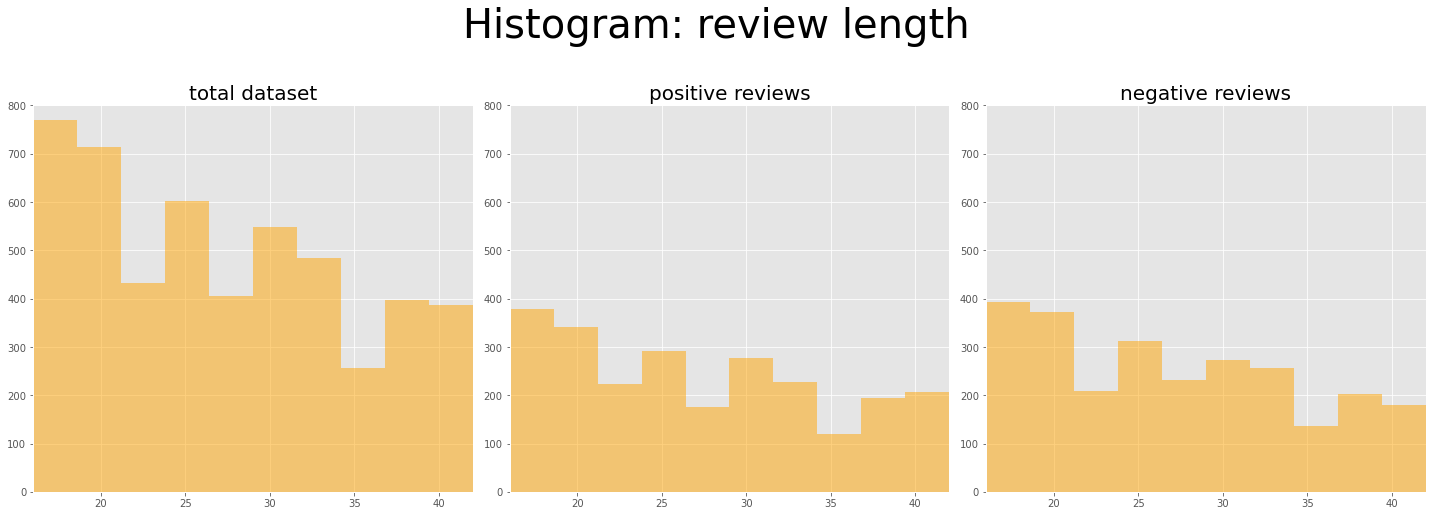

In [20]:
#14 히스토그램을 사용해서 데이터의 분포 확인
plt.figure(figsize=(20,7.5))
plt.suptitle("Histogram: review length", fontsize=40)
name = ['total dataset', 'positive reviews', 'negative reviews'] # 제목으로 사용할 문자열

for i in range(len(compare)):
    document = compare[i]
    string_len = [len(x) for x in document]    
    plt.subplot(1,3,i+1) # 행 개수/ 열 개수/ 해당 그래프 표시 순서
    plt.title(name[i], fontsize=20)
    plt.axis([16, 42, 0, 800])  #x축 시작, 끝 / y축 시작, 끝
    plt.hist(string_len, alpha=0.5, color='orange') # 히스토그램 생성, alpha: 그래프의 투명도 조절
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

총 데이터셋에 각각의 리뷰수를 넣는 시각화를 했으면 더 좋았을 듯 이건 태블로로 해보자.

- 긍정이든 부정이든 리뷰의 길이는 비슷하다. 
- 상대적으로 길이가 짧은 리뷰의 빈도가 더 많다. 

In [22]:
#15 리뷰당 단어수(word) 확인하기 

word_split = data['document'].str.split() # 공백을 기준으로 문자열을 분리
# .stry객체의 문자정보를 추출 
word_split[:5] # 상위 5개 값 확인 , 처음부터 5까지 

0                     [영상이나, 음악이, 이쁘다, 해도, 미화시킨, 불륜일뿐]
1                 [히치콕이, 이, 영화를, 봤다면, 분명, 박수를, 쳤을듯...]
2       [괜찮은, 음악영화가, 또, 나왔군요!!!, 따뜻한, 겨울이, 될, 것, 같아요~]
3                      [아무래도, 20년도지난작품이라, 지금보기는너무유치하다]
4    [지금까지의, 영화들이, 그랬듯., 이, 영화역시, 일본에, 대한, 미화는, 여전하다.]
Name: document, dtype: object

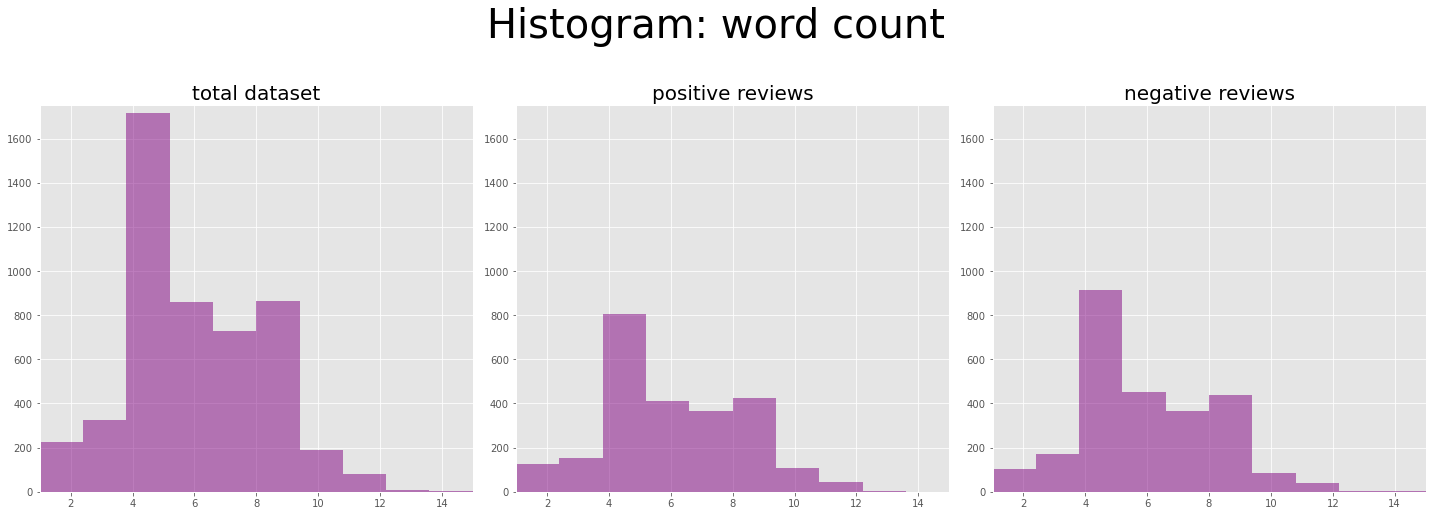

In [25]:
#16 분리된 데이터 히스토그램; 분포 살펴보기 

plt.figure(figsize=(20,7.5))
plt.suptitle("Histogram: word count", fontsize=40)
name = ['total dataset', 'positive reviews', 'negative reviews'] # 제목으로 사용할 문자열

for i in range(len(compare)):
    document = compare[i]
    split = document.str.split()
    split_len = [len(x) for x in split] 
    plt.subplot(1,3,i+1) # 행 개수/ 열 개수/ 해당 그래프 표시 순서
    plt.title(name[i], fontsize=20)
    plt.axis([1, 15, 0, 1750])  #x축 시작, 끝 / y축 시작, 끝
    plt.hist(split_len, alpha=0.5, color='purple')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- 4~9개 어절로 주로 표현.
- 그중에서 4개 어절로 표현 가장 많이함. 
- 4를 빼면 정규분포라고 볼수도 ?

In [26]:
#17 전체 리뷰들을 하나의 문자열로 만듬
def df2str(df):
    
    s = [s for s in df]
    document = ""
    for i in range(len(s)):
        document += s[i]
    return document

In [27]:
#18 명사추출하기 
def get_noun(text):
   
    okt = Okt()
    noun = okt.nouns(text)
    for i,v in enumerate(noun):
        if len(v)<2:
            noun.pop(i)
    count = Counter(noun)
    noun_list = count.most_common(100)

    return noun_list

In [37]:
#19 워드클라우드 이미지 생성하기
def visualize(noun_list, title):
    # 워드클라우드 이미지 생성
    wc= WordCloud(
        font_path = 'a고딕13.ttf',    # 한글폰트 경로 설정
        background_color='white',                             # 배경 색깔 정하기
        colormap = 'Dark2',                                # 폰트 색깔 정하기
        width = 800,
        height = 800).generate_from_frequencies(dict(noun_list)) 
    
    plt.figure(figsize=(10,10)) #이미지 사이즈 지정
    plt.suptitle("Word Cloud", fontsize=40)
    plt.title(title, fontsize=20)
    plt.imshow(wc, interpolation='lanczos') #이미지의 부드럽기 정도
    plt.axis('off') #x y 축 숫자 제거
    plt.show()  # 워드클라우드 이미지 확인
    
    return wc